In [2]:
# Import all required libraries
import pandas as pd
import numpy as np
import requests
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Set seed
np.random.seed(31415926) 

In [3]:
# Load all data required for analysis
# Data includes 
#   - Loitering Events for Carrier and Bunker classed ships
#   - GFW's model output for classifying ships engaged in slave labor
df_fishing_vessels = pd.read_csv("data/fishing-vessels-v2.csv")
df_loiter_carrier = pd.read_csv("data/carrier_loitering_v20210408.csv")
df_loiter_bunker = pd.read_csv("data/bunker_loitering_v20210408.csv")
df_model_raw = pd.read_csv("data/s1_training_final.csv")
df_model_labels = pd.read_csv("data/s4_final_model_predictions.csv")


In [4]:
# Cleanup data and merge different DataFrames to get the final required dataset
merge_on = ["hours","fishing_hours","average_daily_fishing_hours","fishing_hours_foreign_eez","fishing_hours_high_seas","distance_traveled_km"]
df_model = pd.merge(df_model_raw[merge_on + ["mmsi"]],df_model_labels, on=merge_on, how="right" )
# https://stackoverflow.com/questions/15222754/groupby-pandas-dataframe-and-select-most-common-value
df_grouped_mmsi = df_model.groupby("mmsi")["Prediction"].apply(pd.Series.mode).reset_index()#.agg(pd.Series.mode).reset_index()
df_grouped_mmsi = df_grouped_mmsi.drop_duplicates(subset=['mmsi'], keep="last")
df_loiter_data_carrier = pd.merge(df_grouped_mmsi[["mmsi","Prediction"]], df_loiter_carrier, left_on="mmsi", right_on="carrier_mmsi", how="right")
df_loiter_data_bunker = pd.merge(df_grouped_mmsi[["mmsi","Prediction"]], df_loiter_bunker, left_on="mmsi", right_on="bunker_mmsi", how="right")
df_loiter_data = pd.concat([df_loiter_data_carrier,df_loiter_data_bunker])

## Define Class Labeling and encode classes to chosen definitions
IUU_LABEL = 0
NON_IUU_LABEL = 1
UNLABELLED = -1
# Get loiter start hour of day feature. This feature can be useful
df_loiter_data['loitering_start_timestamp'] = pd.to_datetime(df_loiter_data['loitering_start_timestamp'], infer_datetime_format=True)
df_loiter_data['loitering_start_hour'] = df_loiter_data['loitering_start_timestamp'].dt.hour
df_loiter_data['response'] = df_loiter_data['Prediction'].apply(lambda x: IUU_LABEL if x == 'Positive' else (NON_IUU_LABEL if x == 'Negative' else UNLABELLED))
df_loiter_data_unlabeled = df_loiter_data[df_loiter_data['response'] == UNLABELLED].reset_index(drop=True)
df_loiter_data_labeled = df_loiter_data[df_loiter_data['response'] != UNLABELLED].reset_index(drop=True)

# Remove outliers
outliers_labeled = [987]
df_loiter_data_labeled.drop(index=outliers_labeled, inplace=True)

# Extract Relevant columns
rel_cols = ['response','loitering_start_hour','loitering_hours','avg_speed_knots','avg_distance_from_shore_nm']
df_raw_all = df_loiter_data[rel_cols]
df_raw_labeled = df_loiter_data_labeled[rel_cols]
df_raw_unlabeled = df_loiter_data_unlabeled[rel_cols]

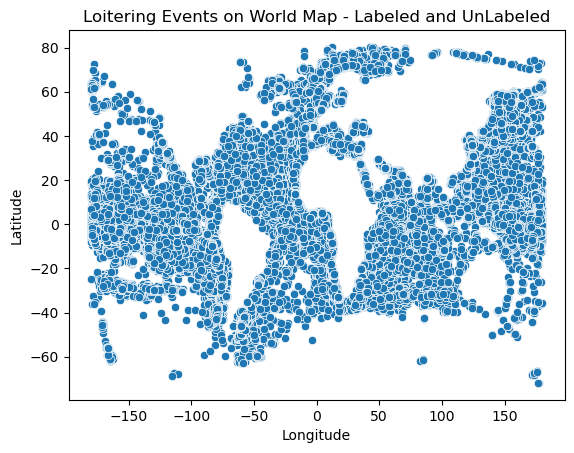

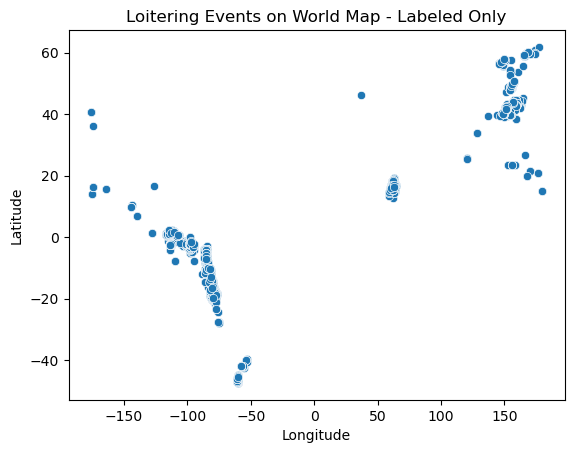

In [5]:
## See locations of all loitering events using latitude and longitude
# ALL DATAPOINTS
ax2 = sns.scatterplot(data=df_loiter_data, x="mean_lon",y="mean_lat")
ax2.set(title="Loitering Events on World Map - Labeled and UnLabeled", xlabel="Longitude", ylabel="Latitude")
plt.show()
# LABELED DATA ONLY
ax1 = sns.scatterplot(data=df_loiter_data_labeled, x="mean_lon",y="mean_lat")
ax1.set(title="Loitering Events on World Map - Labeled Only", xlabel="Longitude", ylabel="Latitude")
plt.show()

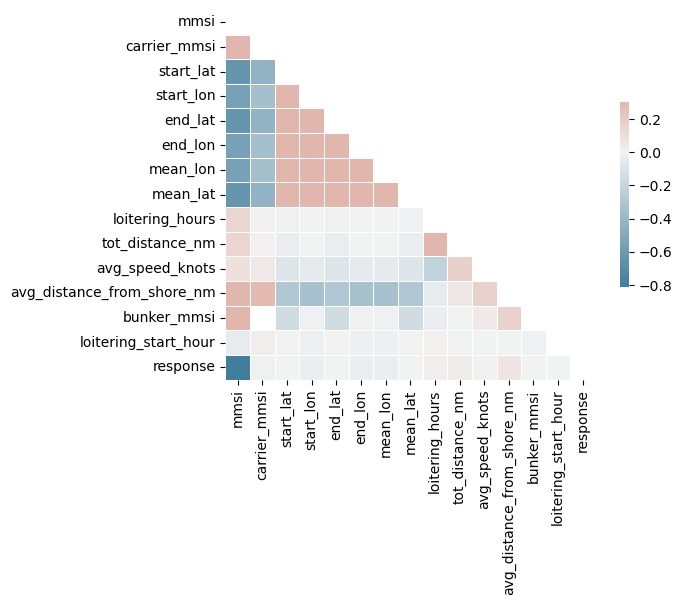

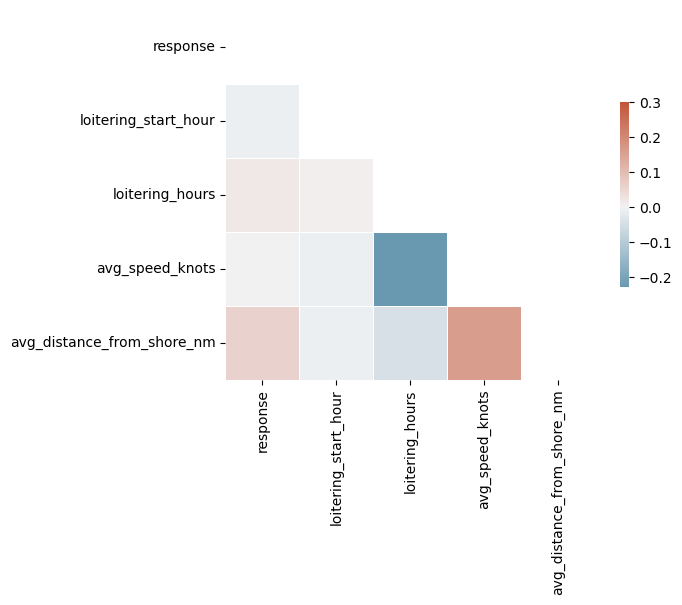

In [6]:
# Correlation Matrix for all Features
corr = df_loiter_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# Correlation Matrix for filtered features
corr = df_raw_all.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

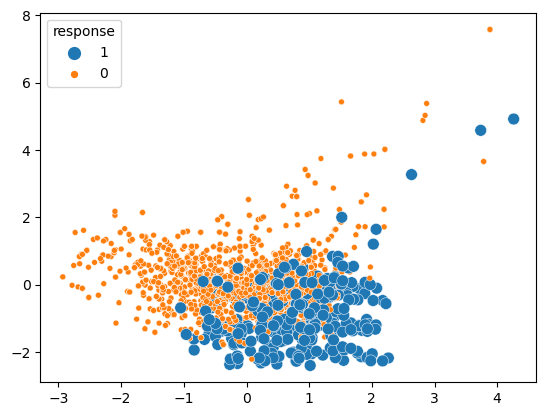

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split

# First Scale Data
scaler = StandardScaler()
df_raw_all_scaled = scaler.fit_transform(df_raw_all.drop(columns='response'))
df_raw_labeled_scaled = scaler.fit_transform(df_raw_labeled.drop(columns='response'))
df_raw_unlabeled_scaled = scaler.fit_transform(df_raw_unlabeled.drop(columns='response'))

# Get Train/Test datasets
X_train = df_raw_labeled_scaled
y_train = df_loiter_data_labeled['response']
X_test = df_raw_all_scaled
y_test = df_loiter_data['response']

# Perform PCA
pca = PCA(3, whiten=True)
PCs = pca.fit(X_train).transform(X_train)
PC1,PC2,PC3 = np.split(PCs, 3, 1)
sns.scatterplot(x=PC1.ravel(), y=PC2.ravel(), hue=y_train.astype(str), size=y_train.astype(str))
plt.show()

In [8]:
# Import required packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, balanced_accuracy_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal as mvn
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM

In [9]:
# Perform Train/Test Splits
scaler = StandardScaler()
df_raw_all_scaled = scaler.fit_transform(df_raw_all.drop(columns='response'))
df_raw_labeled_scaled = scaler.fit_transform(df_raw_labeled.drop(columns='response'))
df_raw_unlabeled_scaled = scaler.fit_transform(df_raw_unlabeled.drop(columns='response'))

df_raw_all_labels = df_raw_all['response']
df_raw_labeled_labels = df_raw_labeled['response']

X_train, X_test, y_train, y_test = train_test_split(df_raw_labeled_scaled, df_raw_labeled_labels, test_size=0.2)

In [10]:
# Setup F-beta scorer
from sklearn.metrics import make_scorer, fbeta_score

BETA = 2.0
fbeta_scorer = make_scorer(fbeta_score, beta=BETA)

In [11]:
# Train Model - Implement GridseachCV and perform Hyperparameter Tuning
logreg = LogisticRegression(penalty='l2')
params = {'C':list(np.arange(0.001, 10, 0.1)),'class_weight':[None, 'balanced']}
gcv = GridSearchCV(logreg, param_grid=params, scoring=fbeta_scorer)
gcv.fit(df_raw_labeled_scaled, df_raw_labeled_labels)

best_model = gcv.best_estimator_
display(best_model)
y_pred = best_model.predict(X_test)
print(f"Bal. Accuracy - Train Set: {balanced_accuracy_score(y_train,best_model.predict(X_train))}")
print(f"Bal. Accuracy - Test Set: {balanced_accuracy_score(y_test,best_model.predict(X_test))}")
print("Confusion Matrix:")
display(confusion_matrix(y_test, y_pred))
print("Classification Report")
print(classification_report(y_test, best_model.predict(X_test)))

LogisticRegression(C=9.701, class_weight='balanced')

Bal. Accuracy - Train Set: 0.8917216828478964
Bal. Accuracy - Test Set: 0.8894093216428242
Confusion Matrix:


array([[357,  37],
       [  7,  48]], dtype=int64)

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       394
           1       0.56      0.87      0.69        55

    accuracy                           0.90       449
   macro avg       0.77      0.89      0.81       449
weighted avg       0.93      0.90      0.91       449



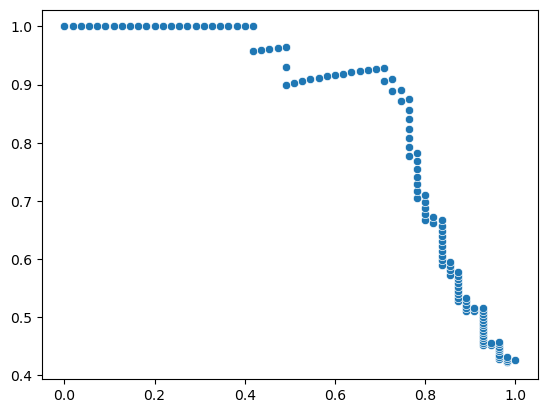

0.6716083955987933

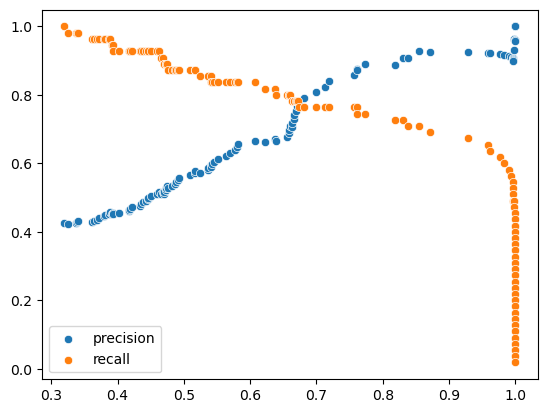

In [12]:
# Example plot
precision, recall, thresholds = precision_recall_curve(y_test,best_model.predict_proba(X_test)[:,1])
sns.scatterplot(x=recall, y=precision)
plt.show()
idx = np.argmin(np.abs(precision-recall))
display(thresholds[idx])
sns.scatterplot(x=thresholds, y=precision[:-1], label='precision')
sns.scatterplot(x=thresholds, y=recall[:-1], label='recall')
plt.show()

In [13]:
gmm = GaussianMixture(n_components=2, covariance_type='full', init_params='random')
gmm.fit(X_train)
y_pred = gmm.predict(X_test)
print(accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.6636971046770601


array([[295,  99],
       [ 52,   3]], dtype=int64)

In [14]:
params = {'C': np.arange(0.0005, 0.01, 0.005),
          'class_weight': [None, 'balanced'],
          'kernel': ['linear', 'rbf'],
        }
svm = SVC(probability=True)
gcv = GridSearchCV(svm, param_grid=params, scoring='balanced_accuracy')
gcv.fit(df_raw_labeled_scaled, df_raw_labeled_labels)

svm_best = gcv.best_estimator_ # Get best model
# Get train and test error
print(f"Bal. Accuracy - Train Set: {balanced_accuracy_score(y_train,svm_best.predict(X_train))}")
print(f"Bal. Accuracy - Test Set: {balanced_accuracy_score(y_test,svm_best.predict(X_test))}")
print("Confusion Matrix:")
display(confusion_matrix(y_test, svm_best.predict(X_test)))
print("Classification Report")
print(classification_report(y_test, svm_best.predict(X_test)))

Bal. Accuracy - Train Set: 0.8631326860841424
Bal. Accuracy - Test Set: 0.8934240886017535
Confusion Matrix:


array([[353,  41],
       [  6,  49]], dtype=int64)

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       394
           1       0.54      0.89      0.68        55

    accuracy                           0.90       449
   macro avg       0.76      0.89      0.81       449
weighted avg       0.93      0.90      0.91       449



In [15]:
params = {'n_estimators': list(range(1,100))
        }
rf = RandomForestClassifier(max_depth=5, 
                            criterion='entropy', 
                            class_weight='balanced')
gcv = GridSearchCV(rf, param_grid=params, scoring=fbeta_scorer)
gcv.fit(df_raw_labeled_scaled, df_raw_labeled_labels)

rf_best = gcv.best_estimator_ # Get best model
rf_best.fit(X_train, y_train)  # Train best model
#visualize = plot_tree(rf_best)

# Get train and test error
rf_best.score(X_test, y_test)
y_pred = rf_best.predict(X_test)
display(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, rf_best.predict(X_test)))

array([[370,  24],
       [  9,  46]], dtype=int64)

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       394
           1       0.66      0.84      0.74        55

    accuracy                           0.93       449
   macro avg       0.82      0.89      0.85       449
weighted avg       0.94      0.93      0.93       449



In [16]:
# Pickle Scaler
with open("scaler",'wb') as file:
    pickle.dump(scaler,file)

# Pickle RandomForest Model that was chosen
with open("model",'wb') as file:
    pickle.dump(rf_best,file)

In [17]:
# Pickle scaler
with open("scaler",'wb') as file:
    pickle.dump(scaler,file)

In [18]:
# Setup CV
MAX_DEPTH = 9
THRESHOLD = 0.8
ITERATIONS = 20
BETA = 2.0

# Setup F-beta scorer
fbeta_scorer = make_scorer(fbeta_score, beta=BETA)

# Setup splits
X_train, X_test, y_train, y_test = train_test_split(df_raw_labeled_scaled, df_raw_labeled_labels, test_size=0.2)


params = {'n_estimators': list(range(1,100))}
rf = RandomForestClassifier(max_depth=MAX_DEPTH, 
                            criterion='entropy', 
                            class_weight='balanced')
gcv = GridSearchCV(rf, param_grid=params, scoring=fbeta_scorer)
gcv.fit(X_train, y_train)

rf_best = gcv.best_estimator_ # Get best model

# Get train and test error
rf_best.score(X_test, y_test)
y_pred = rf_best.predict(X_test)
print("---- Supervised Training ----")
display(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, rf_best.predict(X_test)))

with open("Sup_model_train",'wb') as file:
    pickle.dump(rf_best,file)

# Prepare data
training_features = X_train.copy()
training_labels = y_train.copy()
unlabeled_features = df_raw_unlabeled_scaled.copy()

# Import trained supervised model
with open("Sup_model_train",'rb') as file:
    model = pickle.load(file)

# Run SSL 
for i in range(ITERATIONS):

    # Predict probabilities of unlabeled set
    pred = model.predict_proba(unlabeled_features)[:,1]
    
    # Get indexes of pseudo-labels that meet the threshold
    idxs = np.where((pred > THRESHOLD) | (pred < 1-THRESHOLD))[0]
    
    # Append features
    training_features = np.concatenate([training_features,df_raw_unlabeled_scaled[idxs]])
    
    # Append pseudo-labels
    training_labels = np.concatenate([training_labels, pred[idxs].round(0).astype(int)]) 
    
    # Remove idxs from unlabeled sets
    remove_idxs = np.where(~((pred > THRESHOLD) | (pred < 1-THRESHOLD)))[0]
    unlabeled_features = unlabeled_features[remove_idxs]
    
    # Retrain model
    model.fit(training_features,training_labels)
    
    # Break conditions
    if(len(unlabeled_features) < 50 or len(idxs) == 0):
        break

with open("SSL_final_model",'wb') as file:
    pickle.dump(model,file)

with open("SSL_final_labels",'wb') as file:
    pickle.dump(np.concatenate([training_features, training_labels[:,None]], axis=1),file)

print("---- SSL Training Error ----")
display(confusion_matrix(training_labels,model.predict(training_features)))
print(classification_report(training_labels, model.predict(training_features)))


print("---- SSL Test Error ----")
display(confusion_matrix(y_test,model.predict(X_test)))
print(classification_report(y_test, model.predict(X_test)))

---- Supervised Training ----


array([[378,   6],
       [ 14,  51]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       384
           1       0.89      0.78      0.84        65

    accuracy                           0.96       449
   macro avg       0.93      0.88      0.91       449
weighted avg       0.95      0.96      0.95       449

---- SSL Training Error ----


array([[119680,   7211],
       [ 25873,  36387]], dtype=int64)

              precision    recall  f1-score   support

           0       0.82      0.94      0.88    126891
           1       0.83      0.58      0.69     62260

    accuracy                           0.83    189151
   macro avg       0.83      0.76      0.78    189151
weighted avg       0.83      0.83      0.82    189151

---- SSL Test Error ----


array([[346,  38],
       [  7,  58]], dtype=int64)

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       384
           1       0.60      0.89      0.72        65

    accuracy                           0.90       449
   macro avg       0.79      0.90      0.83       449
weighted avg       0.93      0.90      0.91       449



In [19]:
# Import trained final model
with open("SSL_final_model",'rb') as file:
    final_model = pickle.load(file)

with open("SSL_final_labels",'rb') as file:
    final_dataset = pickle.load(file)
    
with open("scaler",'rb') as file:
    final_scaler = pickle.load(file)

pred = final_model.predict(final_dataset[:,0:-1])

# Prep data
idx = np.where(final_dataset[:,-1] == 1)
training_data = final_dataset[idx, 0:-1][0]

In [20]:
# Train Model
ocsvm = OneClassSVM(kernel='linear')
ocsvm.fit(training_data)

# Get train and test error
y_pred = ocsvm.predict(X_test) # 1 for inliers, -1 for outliers
y_pred[np.where(y_pred == -1)] = 0
display(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

array([[382,   2],
       [ 24,  41]], dtype=int64)

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       384
           1       0.95      0.63      0.76        65

    accuracy                           0.94       449
   macro avg       0.95      0.81      0.86       449
weighted avg       0.94      0.94      0.94       449



In [21]:
# Save model
with open("Anomaly_model",'wb') as file:
    pickle.dump(ocsvm,file)

In [22]:

df = pd.DataFrame({'y_test': np.asarray(y_test), 
                   'y_pred': y_pred,
                   'y_scores': ocsvm.score_samples(X_test)})

# +1 is FP, -1 is FN
df['mismatch'] = df['y_pred'] - df['y_test']
df['Type'] = df['mismatch'].apply(lambda x: 'FN' if x==-1 else ('FP' if x==1 else 'TP & TN'))

Text(0, 0.5, 'OCSVM Score')

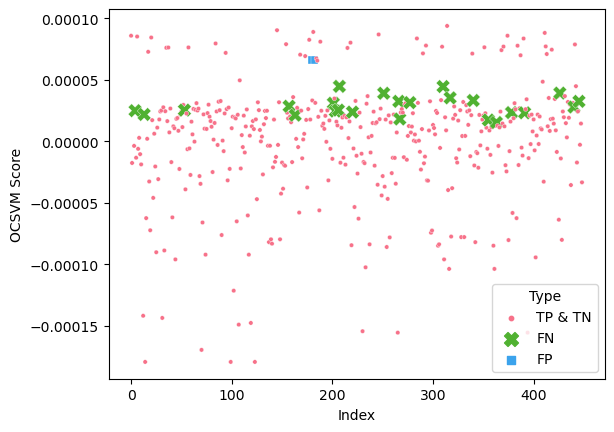

In [23]:
sns.scatterplot(data=df, x=df.index, y='y_scores', hue='Type', palette='husl', style='Type', size='Type', size_order=['TP & TN', 'FP', 'FN'], sizes=(100,10))

plt.xlabel("Index")
plt.ylabel("OCSVM Score")

Text(0, 0.5, 'OCSVM Score')

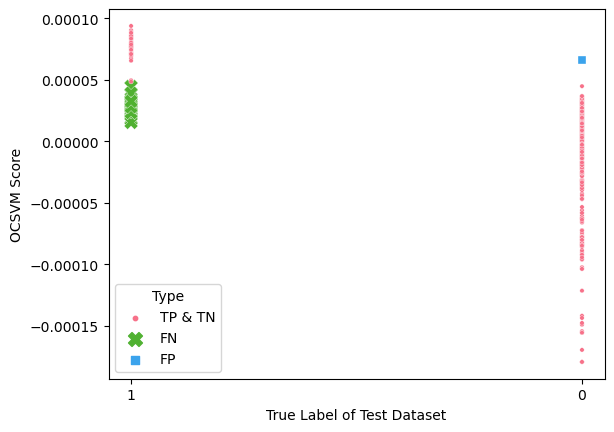

In [24]:
sns.scatterplot(data=df, x=df['y_test'].astype(str), y='y_scores', hue='Type', palette='husl', style='Type', size='Type', size_order=['TP & TN', 'FP', 'FN'], sizes=(100,10))

plt.xlabel("True Label of Test Dataset")
plt.ylabel("OCSVM Score")

Text(0, 0.5, 'OCSVM Score')

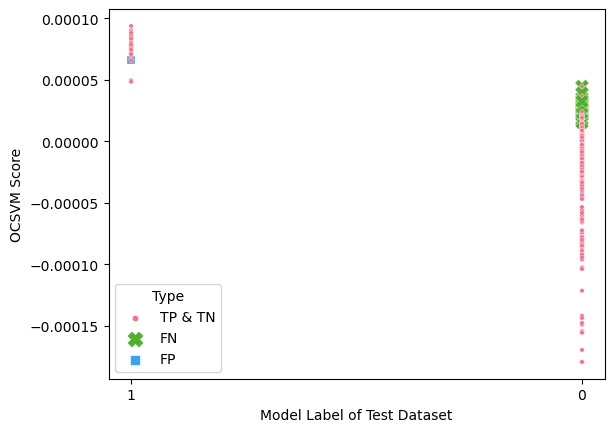

In [25]:
# Shows FN are clustered at lower end of the scoring, so scoring can be used to rank
# FP doesn't matter
sns.scatterplot(data=df, x=df['y_pred'].astype(str), y='y_scores', hue='Type', palette='husl', style='Type', size='Type', size_order=['TP & TN', 'FP', 'FN'], sizes=(100,10))

plt.xlabel("Model Label of Test Dataset")
plt.ylabel("OCSVM Score")

In [26]:
# Feature Importance
a,b,c,d = model.feature_importances_
print("Importance Scores:")
print(f"Loitering Start Hour: {round(a*100,4)}%")
print(f"Loitering Total Hours: {round(b*100,4)}%")
print(f"Average Speed (knots): {round(c*100,4)}%")
print(f"Average Distance from Shore (nautical miles): {round(d*100,4)}%")

Importance Scores:
Loitering Start Hour: 3.7161%
Loitering Total Hours: 5.1861%
Average Speed (knots): 4.0643%
Average Distance from Shore (nautical miles): 87.0335%


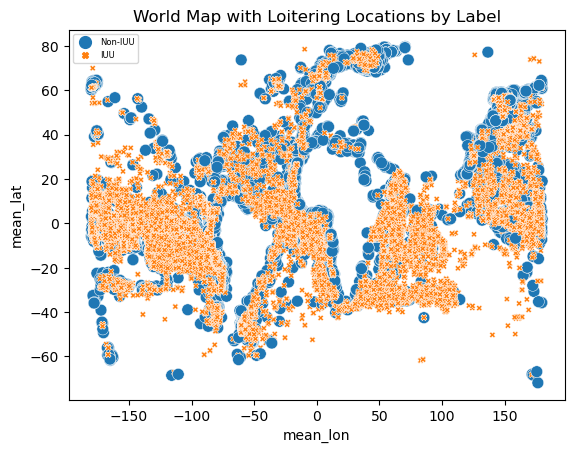

In [65]:
from matplotlib.legend_handler import HandlerPathCollection

x = np.concatenate([final_scaler.inverse_transform(final_dataset[:,:-1]),final_dataset[:,-1][:,None]], axis=1)
df_end = pd.DataFrame(x, columns=['loitering_start_hour', 'loitering_hours', 'avg_speed_knots','avg_distance_from_shore_nm','response'])

y = df_loiter_data.merge(df_end, how='inner', on=['loitering_hours', 'avg_speed_knots','avg_distance_from_shore_nm'])
y = y.rename(columns={'response_y':"Label"})
y['Label'] = y['Label'].apply(lambda x: "IUU" if x==0 else 'Non-IUU')

sc = sns.scatterplot(data=y, x="mean_lon",y="mean_lat", hue='Label', size='Label', style='Label')
plt.title('World Map with Loitering Locations by Label')

plt.legend(fontsize=6, markerscale=1)
plt.show()